In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from IPython.display import display
from typing import List, Tuple
from functools import cache
import yfinance as yf
import matplotlib

In [ ]:
# Set constants for Treasury Bill rate and trading days per year
TREASURY_BILL_RATE = 0.048  # As of 28th April 2023
TRADING_DAYS_PER_YEAR = 252

In [ ]:
# Define the Asset class here for type hinting purposes
class Asset:
    pass


def get_log_period_returns(price_history: pd.DataFrame):
    """
    Compute the log-period returns from a Pandas DataFrame of historical asset prices.

    Args:
    - price_history (pd.DataFrame): A DataFrame containing the historical prices of an asset.

    Returns:
    - np.ndarray: A 2D NumPy array containing the log-period returns.
    """
    close = price_history['Close'].values  
    return np.log(close[1:] / close[:-1]).reshape(-1, 1)

In [ ]:
# daily_price_history has to at least have a column, called 'Close'
class Asset:
    """
    A class to represent an asset.

    Attributes:
        name: A string representing the name of the asset.
        daily_returns: A numpy array representing the daily returns of the asset.
        expected_daily_return: A float representing the expected daily return of the asset.
    """
    def __init__(self, name: str, daily_price_history: pd.DataFrame):
        """
        Initializes an Asset object.

        Args:
            name: A string representing the name of the asset.
            daily_price_history: A pandas DataFrame representing the daily price history of the asset.
                                  Must have a column called 'Close'.
        """
        self.name = name
        self.daily_returns = get_log_period_returns(daily_price_history)
        self.expected_daily_return = np.mean(self.daily_returns)

    @property
    def expected_return(self):
        """
        Calculates the expected annual return of the asset.

        Returns:
            A float representing the expected annual return of the asset.
        """
        return TRADING_DAYS_PER_YEAR * self.expected_daily_return

    def __repr__(self):
        """
        Returns a string representation of the Asset object.

        Returns:
            A string representation of the Asset object.
        """
        return f'<Asset name={self.name}, expected return={self.expected_return}>'

    @staticmethod
    @cache
    def covariance_matrix(assets: Tuple[Asset]):
        """
        Calculates the covariance matrix of a list of assets.

        Args:
            assets: A tuple of Asset objects.

        Returns:
            A numpy array representing the covariance matrix of the assets.
        """
        product_expectation = np.zeros((len(assets), len(assets)))
        for i in range(len(assets)):
            for j in range(len(assets)):
                if i == j:
                    product_expectation[i][j] = np.mean(assets[i].daily_returns * assets[j].daily_returns)
                else:
                    product_expectation[i][j] = np.mean(assets[i].daily_returns @ assets[j].daily_returns.T)

        product_expectation *= (TRADING_DAYS_PER_YEAR - 1) ** 2

        expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
        product_of_expectations = expected_returns @ expected_returns.T

        return product_expectation - product_of_expectations


    def random_weights(weight_count):
        """
        Generates a numpy array of random weights.

        Args:
            weight_count: An integer representing the number of weights to generate.

        Returns:
            A numpy array representing the random weights.
        """
        weights = np.random.random((weight_count, 1))
        weights /= np.sum(weights)
        return weights.reshape(-1, 1)


In [ ]:
class Portfolio:
    """
    A class representing a portfolio of assets.

    Attributes:
    - assets (Tuple[Asset]): A tuple of Asset objects representing the assets in the portfolio.
    - asset_expected_returns (np.ndarray): A 2D NumPy array containing the expected returns of each asset in the portfolio.
    - covariance_matrix (np.ndarray): A 2D NumPy array containing the covariance matrix of the portfolio assets.
    - weights (np.ndarray): A 2D NumPy array containing the portfolio weights.

    Methods:
    - unsafe_optimize_with_risk_tolerance(risk_tolerance: float): An internal method that optimizes the portfolio weights
    subject to a risk tolerance constraint.
    - optimize_with_risk_tolerance(risk_tolerance: float): A method that optimizes the portfolio weights subject to a risk
    tolerance constraint.
    - optimize_with_expected_return(expected_portfolio_return: float): A method that optimizes the portfolio weights subject
    to an expected portfolio return constraint.
    - optimize_sharpe_ratio(): A method that optimizes the portfolio weights to maximize the Sharpe ratio.
    - _expected_return(w): An internal method that computes the expected return of the portfolio given a set of weights.
    - _variance(w): An internal method that computes the variance of the portfolio given a set of weights.
    - expected_return(): A property that returns the expected return of the portfolio.
    - variance(): A property that returns the variance of the portfolio.
    - __repr__(): A special method that returns a string representation of the Portfolio object.

    """

    def __init__(self, assets: Tuple[Asset]):
        """
        Initialize the portfolio with a tuple of assets, and calculate expected returns, covariance matrix, and random
        initial weights.

        Args:
            assets: a tuple of Asset objects
        """
        self.assets = assets
        self.asset_expected_returns = np.array([asset.expected_return for asset in assets]).reshape(-1, 1)
        self.covariance_matrix = Asset.covariance_matrix(assets)
        self.weights = Asset.random_weights(len(assets))

    def unsafe_optimize_with_risk_tolerance(self, risk_tolerance: float) -> None:
        """
        Optimize the portfolio weights to maximize the expected return with a given risk tolerance.

        Args:
            risk_tolerance: a float indicating the maximum risk tolerance for the portfolio
        """
        res = minimize(
          lambda w: self._variance(w) - risk_tolerance * self._expected_return(w),
          Asset.random_weights(self.weights.size),
          constraints=[
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
          ],
          bounds=[(0., 1.) for i in range(self.weights.size)]
        )

        assert res.success, f'Optimization failed: {res.message}'
        self.weights = res.x.reshape(-1, 1)

    def optimize_with_risk_tolerance(self, risk_tolerance: float) -> None:
        """
        Optimize the portfolio weights to maximize the expected return with a given risk tolerance.

        Args:
            risk_tolerance: a float indicating the maximum risk tolerance for the portfolio
        """
        assert risk_tolerance >= 0.
        self.unsafe_optimize_with_risk_tolerance(risk_tolerance)

    def optimize_with_expected_return(self, expected_portfolio_return: float) -> None:
        """
        Optimize the portfolio weights to maximize the expected return with a given expected portfolio return.

        Args:
            expected_portfolio_return: a float indicating the expected portfolio return
        """
        res = minimize(
          lambda w: self._variance(w),
          Asset.random_weights(self.weights.size),
          constraints=[
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
            {'type': 'eq', 'fun': lambda w: self._expected_return(w) - expected_portfolio_return},
          ],
          bounds=[(0., 1.) for i in range(self.weights.size)]
        )

        assert res.success, f'Optimization failed: {res.message}'
        self.weights = res.x.reshape(-1, 1)

    def optimize_sharpe_ratio(self):
        """
        Optimize the portfolio weights to maximize the Sharpe ratio, which is the excess return of the portfolio over
        the risk-free rate divided by the portfolio's standard deviation.

        Returns:
            None
        """
        # Define the objective function to minimize (negative Sharpe ratio)
        objective_func = lambda w: -(self._expected_return(w) - TREASURY_BILL_RATE / 100) / np.sqrt(self._variance(w))

        # Set up the optimization problem with constraints on the sum of the weights
        problem = {
            'fun': objective_func,
            'x0': Asset.random_weights(self.weights.size),
            'constraints': [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1.}],
            'bounds': [(0., 1.) for i in range(self.weights.size)]
        }

        # Use the minimize function to solve the optimization problem
        res = minimize(**problem)

        # Check if optimization succeeded, and update the portfolio weights with the optimal values
        assert res.success, f'Optimization failed: {res.message}'
        self.weights = res.x.reshape(-1, 1)

    
    def _expected_return(self, w):
        """
        Calculates the expected return of a portfolio with given weights.
        
        Args:
            w (numpy.ndarray): A vector of weights.
            
        Returns:
            float: The expected return of the portfolio.
        """
        return (self.asset_expected_returns.T @ w.reshape(-1, 1))[0][0]

    def _variance(self, w):
        """
        Calculates the variance of a portfolio with given weights.
        
        Args:
            w (numpy.ndarray): A vector of weights.
            
        Returns:
            float: The variance of the portfolio.
        """
        return (w.reshape(-1, 1).T @ self.covariance_matrix @ w.reshape(-1, 1))[0][0]

    @property
    def expected_return(self):
        """
        Returns the expected return of the portfolio.
        
        Returns:
            float: The expected return of the portfolio.
        """
        return self._expected_return(self.weights)

    @property
    def variance(self):
        """
        Returns the variance of the portfolio.
        
        Returns:
            float: The variance of the portfolio.
        """
        return self._variance(self.weights)

    def __repr__(self):
        """
        Returns a string representation of the Portfolio object.
        
        Returns:
            str: A string representation of the Portfolio object.
        """
        return f'<Portfolio assets={[asset.name for asset in self.assets]}, expected return={self.expected_return}, variance={self.variance}>'


In [ ]:
def yf_retrieve_data(tickers: List[str]):
    """
    Retrieve historical data for a list of tickers using Yahoo Finance API.

    Args:
        tickers (List[str]): a list of strings representing the tickers to retrieve data for.

    Returns:
        A list of pandas DataFrame objects representing the historical data for each ticker.

    Raises:
        AssertionError: if any retrieved data contains NaN values.
    """

    dataframes = []

    for ticker_name in tickers:
        # Retrieve data for the current ticker
        ticker = yf.Ticker(ticker_name)
        history = ticker.history(period='10y')

        # Check if the first row contains NaN values and remove it if necessary
        if history.isnull().any(axis=1).iloc[0]:
            history = history.iloc[1:]

        # Ensure that there are no NaN values in the retrieved data
        assert not history.isnull().any(axis=None), f'history has NaNs in {ticker_name}'

        # Add the retrieved data to the list of dataframes
        dataframes.append(history)

    return dataframes


In [ ]:
# Define a list of stocks to retrieve data for
stocks = ['AAPL', 'AMZN', 'GOOG', 'BRK-B', 'JNJ', 'JPM']

# Retrieve historical data for the list of stocks
daily_dataframes = yf_retrieve_data(stocks)

# Create an Asset object for each stock
assets = tuple([Asset(name, daily_df) for name, daily_df in zip(stocks, daily_dataframes)])

# print the assets
assets

(<Asset name=AAPL, expected return=0.25506305634808185>,
 <Asset name=AMZN, expected return=0.21352433751805916>,
 <Asset name=GOOG, expected return=0.16699549059295815>,
 <Asset name=BRK-B, expected return=0.11264056472380501>,
 <Asset name=JNJ, expected return=0.09207176566251563>,
 <Asset name=JPM, expected return=0.13194256114256947>)

<ipython-input-14-d91397de48b9>:47: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(
<ipython-input-14-d91397de48b9>:76: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(
<ipython-input-14-d91397de48b9>:109: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(**problem)


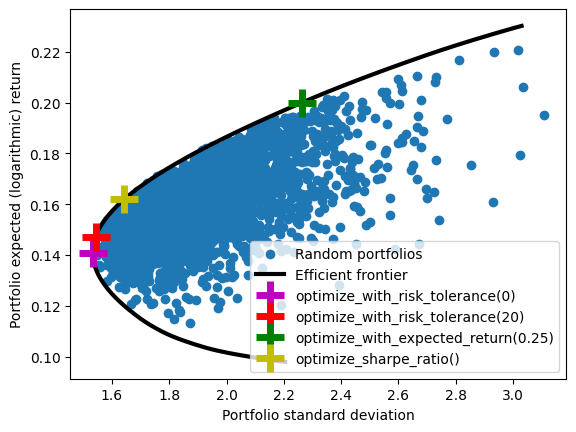

In [ ]:
# Define empty lists to store data points
X = []
y = []

# Drawing random portfolios
for i in range(3000):
    portfolio = Portfolio(assets)
    X.append(np.sqrt(portfolio.variance))
    y.append(portfolio.expected_return)

plt.scatter(X, y, label='Random portfolios')

# Drawing the efficient frontier
X = []
y = []
for rt in np.linspace(-300, 200, 1000):
    portfolio.unsafe_optimize_with_risk_tolerance(rt)
    X.append(np.sqrt(portfolio.variance))
    y.append(portfolio.expected_return)

plt.plot(X, y, 'k', linewidth=3, label='Efficient frontier')

# Drawing optimized portfolios
portfolio.optimize_with_risk_tolerance(0)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'm+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(0)')

portfolio.optimize_with_risk_tolerance(10)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'r+', markeredgewidth=5, markersize=20, label='optimize_with_risk_tolerance(20)')

portfolio.optimize_with_expected_return(0.2)
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'g+', markeredgewidth=5, markersize=20, label='optimize_with_expected_return(0.25)')

portfolio.optimize_sharpe_ratio()
plt.plot(np.sqrt(portfolio.variance), portfolio.expected_return, 'y+', markeredgewidth=5, markersize=20, label='optimize_sharpe_ratio()')

# Add axis labels and legend
plt.xlabel('Portfolio standard deviation')
plt.ylabel('Portfolio expected (logarithmic) return')
plt.legend(loc='lower right')

# Display the plot
plt.show()


In [ ]:
# Create a portfolio object using the given assets
portfolio = Portfolio(assets)

# Optimize the portfolio weights for risk tolerance of 0 and store the resulting weights
portfolio.optimize_with_risk_tolerance(0)
riskless_weights = portfolio.weights.flatten()

# Optimize the portfolio weights for a risk tolerance of 10 and store the resulting weights
portfolio.optimize_with_risk_tolerance(10)
weights_risk_tolerance = portfolio.weights.flatten()

# Optimize the portfolio weights for an expected return of 0.2 and store the resulting weights
portfolio.optimize_with_expected_return(0.2)
weights_return = portfolio.weights.flatten()

# Optimize the portfolio weights for maximum Sharpe ratio and store the resulting weights
portfolio.optimize_sharpe_ratio()
weights_sharpe = portfolio.weights.flatten()

# Create a pandas DataFrame to display the weights for each asset and each optimization method
weights_data = pd.DataFrame(
    list(
        zip(
            [asset.name for asset in portfolio.assets],
            riskless_weights,
            weights_risk_tolerance,
            weights_return,
            weights_sharpe,
        )
    ),
    columns=[
        'asset',
        'optimize_with_risk_tolerance(0)',
        'optimize_with_risk_tolerance(10)',
        'optimize_with_expected_return(0.2)',
        'optimize_sharpe_ratio()',
    ],
)

# Display the DataFrame
display(weights_data)


<ipython-input-14-d91397de48b9>:47: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(
<ipython-input-14-d91397de48b9>:76: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(
<ipython-input-14-d91397de48b9>:109: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  res = minimize(**problem)


,asset,optimize_with_risk_tolerance(0),optimize_with_risk_tolerance(10),optimize_with_expected_return(0.2),optimize_sharpe_ratio()
0,AAPL,0.114764,0.142594,0.376440,0.207854
1,AMZN,0.087388,0.100873,0.214144,0.132283
2,GOOG,0.123883,0.130739,0.188360,0.147076
3,BRK-B,0.251488,0.236340,0.109024,0.201309
4,JNJ,0.293672,0.263113,0.006482,0.191135
5,JPM,0.128804,0.126341,0.105549,0.120343
